### Load the data

In [51]:
import torch
from transformer_lens import HookedTransformer, HookedTransformerConfig
from neel_plotly.plot import line
from helpers import loss_fn
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, estimate_learning_coeff, SGLD
from devinterp.utils import plot_trace
import tqdm.auto as tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
RAND_SEED = 42

LOAD_LOCATION = "../saves/check_point_50/grokking_add_multi_0.5.pth"

cached_data = torch.load(LOAD_LOCATION, weights_only=False)

state_dict = cached_data['model']
model_checkpoints = cached_data["checkpoints"]
checkpoint_epochs = cached_data["checkpoint_epochs"]
test_losses = cached_data['test_losses']
train_losses = cached_data['train_losses']
add_test_losses = cached_data['add_test_losses']
multi_test_losses = cached_data['multi_test_losses']
max_nums = cached_data['max_nums']
mod_value = cached_data['mod_value']
train_frac = cached_data['train_frac']
addition_frac = cached_data['addition_frac']
train_data = cached_data['train_data']
train_labels = cached_data['train_labels']

print(f"train_frac = {train_frac} addition_frac = {addition_frac}")
print(f"len(train_losses) = {len(train_losses)} len(test_losses) = {len(test_losses)} len(model_checkpoints) = {len(model_checkpoints)}")

train_frac = 0.5 addition_frac = 0.5
len(train_losses) = 6000 len(test_losses) = 6000 len(model_checkpoints) = 120


In [46]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)

### Setup the Model

In [47]:
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 4,
    d_model = 128,
    d_head = 32,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type="LN",
    d_vocab=max_nums+1,
    d_vocab_out=mod_value,
    n_ctx= 3,
    init_weights=True,
    device=device,
    seed = RAND_SEED,
)

model = HookedTransformer(cfg)

### Local Learning Coefficient (RLCT) Estimation

#### Config

In [48]:
lr = 1e-5
localization = 100.0
num_chains = 1
num_draws = 400
num_burnin_steps = 100
num_steps_bw_draws = 1
noise_level = 1.0

def evaluate(model, data):
    inputs, outputs = data

    return loss_fn(model(inputs), outputs), {
        "logits": model(inputs)
    }

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:54: UserWarning: nbeta not set - using default nbeta.
  warnings.warn("nbeta not set - using default nbeta.")
/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:211: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:234: UserWarning: If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(


len(model_checkpoints) = 120
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 51.58it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 59.35it/s]


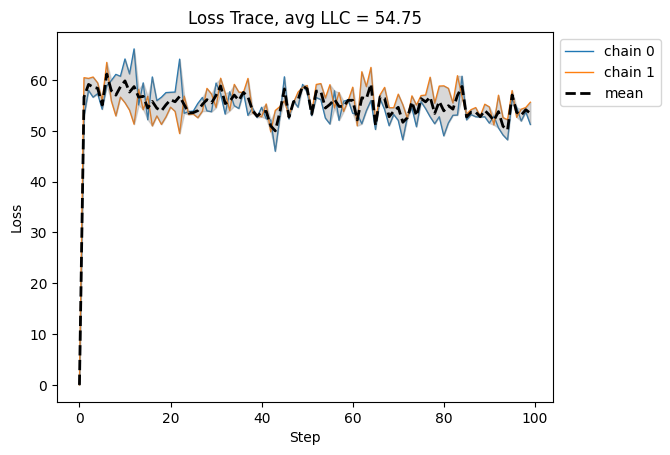

<Figure size 1200x900 with 0 Axes>

In [49]:
print(f"len(model_checkpoints) = {len(model_checkpoints)}")

model.load_state_dict(model_checkpoints[40])

results = estimate_learning_coeff_with_summary(
                model,
                loader=train_loader,
                evaluate=evaluate,
                sampling_method=SGLD,
                optimizer_kwargs=dict(lr=lr, localization=localization, noise_level=noise_level),
                num_chains=num_chains,                  # How many independent chains to run
                num_draws=num_draws,                    # How many samples to draw per chain
                num_burnin_steps=num_burnin_steps,      # How many samples to discard at the beginning of each chain
                num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
                device=device,
                online=True,
            )

plot_trace(
    results["llc/trace"],
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(results['llc/means']) / len(results['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)

In [50]:
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, estimate_learning_coeff, SGLD
from devinterp.utils import plot_trace

def evaluate(model, data):
    inputs, outputs = data

    return loss_fn(model(inputs), outputs), {
        "logits": model(inputs)
    }

llc_estimates = []

for saved_model in tqdm.tqdm(model_checkpoints):
    model.load_state_dict(saved_model)
    result = estimate_learning_coeff(
                model,
                loader=train_loader,
                evaluate=evaluate,
                sampling_method=SGLD,
                optimizer_kwargs=dict(lr=lr, localization=localization),
                num_chains=num_chains,                  # How many independent chains to run
                num_draws=num_draws,                    # How many samples to draw per chain
                num_burnin_steps=num_burnin_steps,      # How many samples to discard at the beginning of each chain
                num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
                device=device,
                #online=True,
            )
    llc_estimates.append(result)
    print(f"result = {result}")

# Graph the LLC estimates
line(llc_estimates, xaxis="Epoch", yaxis="LLC", title="Learning Coefficient Estimates", log_y=False, toggle_x=True, toggle_y=True)

  0%|          | 0/120 [00:00<?, ?it/s]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 47.76it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 57.04it/s]


result = 4.8560967445373535
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 53.25it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 56.11it/s]


result = 26.826580047607422
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 57.96it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 54.26it/s]


result = 43.96349334716797
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 51.84it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 53.33it/s]


result = 53.972503662109375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 43.25it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 47.75it/s]


result = 57.95348358154297
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 50.83it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 54.41it/s]


result = 60.602535247802734
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 54.79it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 52.85it/s]


result = 62.66954040527344
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 56.27it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 52.40it/s]


result = 63.88574981689453
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 55.89it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 48.66it/s]


result = 65.11664581298828
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 51.54it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 56.39it/s]


result = 66.68025970458984
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 54.05it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 38.96it/s]


result = 66.67961120605469
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 42.07it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 59.41it/s]


result = 67.24105072021484
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 49.14it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 39.81it/s]


result = 65.1914291381836
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 42.04it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 49.93it/s]


result = 64.90739440917969
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 45.58it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 48.90it/s]


result = 64.94940948486328
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 56.07it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 57.87it/s]


result = 65.5922622680664
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 50.39it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 46.70it/s]


result = 66.71078491210938
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 52.10it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 41.30it/s]


result = 66.1048583984375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 45.19it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 48.25it/s]


result = 64.36421203613281
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 51.81it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 55.88it/s]


result = 63.56479263305664
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 43.97it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 53.89it/s]


result = 62.570701599121094
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 48.21it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 58.91it/s]


result = 61.818241119384766
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 61.22it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 57.50it/s]


result = 62.06399154663086
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 55.93it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 45.09it/s]


result = 61.429100036621094
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 40.43it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 46.00it/s]


result = 57.57035827636719
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 53.49it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 50.56it/s]


result = 58.374053955078125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 50.32it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 50.96it/s]


result = 58.34075927734375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 47.26it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 52.19it/s]


result = 57.87546920776367
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 54.66it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 51.94it/s]


result = 56.98810577392578
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 53.11it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 50.40it/s]


result = 55.47317123413086
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 55.58it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 50.77it/s]


result = 56.619476318359375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 40.38it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 41.57it/s]


result = 56.82076644897461
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 50.36it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 53.34it/s]


result = 56.08700180053711
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 44.81it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 53.57it/s]


result = 56.07122039794922
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 50.59it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 50.65it/s]


result = 52.533592224121094
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 53.50it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 49.55it/s]


result = 55.73870849609375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 53.75it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 50.96it/s]


result = 55.929542541503906
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 55.57it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 55.15it/s]


result = 55.84209060668945
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 51.37it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 53.96it/s]


result = 55.23268127441406
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 50.12it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 49.94it/s]


result = 55.04711151123047
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 51.49it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 50.12it/s]


result = 54.70491027832031
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 55.01it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 38.35it/s]


result = 54.315155029296875
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 44.60it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 37.38it/s]


result = 55.078102111816406
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 40.08it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 37.32it/s]


result = 54.548274993896484
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 41.47it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 42.53it/s]


result = 56.04308319091797
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 45.31it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 46.15it/s]


result = 55.41169738769531
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 45.38it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 39.18it/s]


result = 54.76711654663086
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 44.78it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 43.14it/s]


result = 54.75993728637695
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 41.49it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 50.25it/s]


result = 53.50688934326172
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 54.17it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 54.19it/s]


result = 54.188087463378906
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 50.28it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 55.57it/s]


result = 55.815643310546875
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 55.23it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 52.35it/s]


result = 31.85475730895996
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 54.29it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 48.26it/s]


result = 55.35626983642578
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 46.91it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 45.73it/s]


result = 53.9013671875
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 47.64it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 55.13it/s]


result = 53.84963607788086
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.48it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 48.09it/s]


result = 52.852577209472656
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 53.61it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 37.12it/s]


result = 54.48303985595703
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 46.88it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 47.47it/s]


result = 53.82422637939453
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 44.41it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 46.38it/s]


result = 54.333839416503906
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 50.06it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 43.71it/s]


result = 52.25223922729492
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 50.98it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 48.04it/s]


result = 56.341529846191406
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 55.44it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 54.10it/s]


result = 54.03968811035156
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 45.93it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 46.18it/s]


result = 52.94291687011719
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 45.81it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 43.63it/s]


result = 54.036651611328125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 51.09it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 45.16it/s]


result = 54.449562072753906
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 57.14it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 49.44it/s]


result = 54.50941467285156
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 47.17it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 46.44it/s]


result = 54.21611785888672
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 40.93it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 45.79it/s]


result = 56.048912048339844
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 46.32it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 41.51it/s]


result = 54.787811279296875
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.83it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 46.27it/s]


result = 54.349700927734375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.32it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 44.57it/s]


result = 53.83039855957031
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 58.45it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 51.96it/s]


result = 52.77189254760742
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 57.42it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 38.07it/s]


result = 54.05744171142578
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 46.02it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 56.87it/s]


result = 54.0078125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 59.61it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 60.26it/s]


result = 54.97191619873047
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 56.48it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 62.81it/s]


result = 55.27165985107422
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 56.21it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 45.65it/s]


result = 55.112159729003906
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 58.61it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 52.25it/s]


result = 54.54940414428711
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 60.98it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 63.20it/s]


result = 55.93580627441406
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 57.62it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 62.70it/s]


result = 55.704097747802734
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 63.81it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 60.35it/s]


result = 56.61967468261719
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 64.50it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 62.88it/s]


result = 58.51410675048828
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 58.37it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 58.93it/s]


result = 59.09088134765625
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 52.65it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 55.08it/s]


result = 56.04296875
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 59.96it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 56.42it/s]


result = 55.208900451660156
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 65.63it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 62.25it/s]


result = 54.27403259277344
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 57.18it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 53.61it/s]


result = 54.779640197753906
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 51.94it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 60.54it/s]


result = 53.233482360839844
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 61.30it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 51.99it/s]


result = 54.471214294433594
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 61.17it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 52.53it/s]


result = 54.41887664794922
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 61.54it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 57.61it/s]


result = 54.90850067138672
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 63.59it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 63.25it/s]


result = 56.14268112182617
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 49.08it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 46.77it/s]


result = 58.07970428466797
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 48.50it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 61.83it/s]


result = 57.439613342285156
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 62.21it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 58.09it/s]


result = 57.77094268798828
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 61.07it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 48.12it/s]


result = 57.91777801513672
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 42.06it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:02<00:00, 48.96it/s]


result = 57.820640563964844
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 57.52it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 63.43it/s]


result = 56.93232727050781
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 61.37it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 60.26it/s]


result = 56.69666290283203
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 63.36it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 56.92it/s]


result = 54.981651306152344
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 64.73it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 61.56it/s]


result = 52.88319778442383
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 66.38it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 61.67it/s]


result = 53.93695831298828
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 58.69it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 64.80it/s]


result = 54.13008117675781
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 65.04it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 61.97it/s]


result = 53.00030517578125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 66.66it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 61.05it/s]


result = 53.740604400634766
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 63.66it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 65.39it/s]


result = 55.133338928222656
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 62.56it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 66.70it/s]


result = 54.86053466796875
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 65.58it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 62.77it/s]


result = 56.952613830566406
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 66.53it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 63.75it/s]


result = 56.33762741088867
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 63.93it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 67.89it/s]


result = 56.686668395996094
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 62.36it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 65.89it/s]


result = 57.925907135009766
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 66.00it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 65.27it/s]


result = 58.28656768798828
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 69.80it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 68.08it/s]


result = 58.60088348388672
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 63.35it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 68.39it/s]


result = 55.75856399536133
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 61.58it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 63.98it/s]


result = 54.75509262084961
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 69.93it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 67.42it/s]


result = 54.80225372314453
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 64.38it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 67.69it/s]


result = 54.395606994628906
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 66.07it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 63.71it/s]


result = 53.897029876708984
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 64.75it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 66.81it/s]


result = 53.93266296386719
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 65.40it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 100/100 [00:01<00:00, 69.12it/s]


result = 53.67479705810547


### Save the data

In [ ]:
SAVE_LOCATION = "../saves/check_point_50/llc_estimates.pth"
SAVE = False
if SAVE:
    torch.save({
        "llc_estimates": llc_estimates,
    }, SAVE_LOCATION)

## Make some cool graphs

In [ ]:
line(llc_estimates, xaxis="Epoch", yaxis="LLC", title="Learning Coefficient Estimates", log_y=False, toggle_x=True, toggle_y=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your data prepared as before
epochs = np.arange(0, 4000, 10)
lc_epochs = np.arange(0, 4000, 100)

# Set up the plot
plt.figure(figsize=(12, 6))
sns.set_style("ticks")

# Create the main axis
ax1 = plt.gca()

# Plot loss curves
ax1.plot(epochs, test_losses_avg[::10], color=colors[0], label='Test Loss', linewidth=2)
ax1.plot(epochs, train_losses_avg[::10], color=colors[1], label='Train Loss', linewidth=2)
#ax1.plot(epochs, add_test_losses_avg, color=colors[2], label='Addition Only Test Loss', linewidth=2)
#ax1.plot(epochs, multi_test_losses_avg, color=colors[3], label='Multiplication Only Test Loss', linewidth=2)

# Set up the second y-axis for learning coefficient
ax2 = ax1.twinx()
ax2.plot(lc_epochs, llc_estimates[:4000], color=colors[4], linestyle='--', label='Learning Coefficient', linewidth=2)

# Customize the plot
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Rolling Avg Loss', fontsize=12)
ax2.set_ylabel('Learning Coefficient', fontsize=12)
plt.title(f"Loss and LLC During Training - {addition_frac*100:.0f}% Addition", fontsize=14)

# Adjust tick parameters
ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='y', which='major', labelsize=10)

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right') # bbox_to_anchor=(1.1, 1), fontsize=10)

plt.tight_layout()
plt.show()